<a href="https://colab.research.google.com/github/pal1501/Movie-Recommendation/blob/main/Personalized_Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LOADING DATASET

In [6]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

In [7]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
links = pd.read_csv('links.csv')
tags = pd.read_csv('tags.csv')

In [8]:
print("Ratings Data:")
print(ratings.head())

print("\nMovies Data:")
print(movies.head())

Ratings Data:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [9]:
# Check for missing values
print("Missing in ratings:", ratings.isnull().sum())
print("Missing in movies:", movies.isnull().sum())

# Drop duplicates if any
ratings.drop_duplicates(inplace=True)
movies.drop_duplicates(inplace=True)
print("Duplicates removed")

Missing in ratings: userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing in movies: movieId    0
title      0
genres     0
dtype: int64
Duplicates removed


#CONVERT CATEGORICAL DATA (Genres → Multi-label One-hot Encoding)

In [10]:
# Split genres into lists
movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if x != '(no genres listed)' else [])

In [11]:
# Use MultiLabelBinarizer for one-hot encoding
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(movies['genres']), columns=mlb.classes_)
# Combine back with movies dataframe
movies = pd.concat([movies.drop('genres', axis=1), genre_encoded], axis=1)

print("Genres after one-hot encoding:\n", movies.head())

Genres after one-hot encoding:
    movieId                               title  Action  Adventure  Animation  \
0        1                    Toy Story (1995)       0          1          1   
1        2                      Jumanji (1995)       0          1          0   
2        3             Grumpier Old Men (1995)       0          0          0   
3        4            Waiting to Exhale (1995)       0          0          0   
4        5  Father of the Bride Part II (1995)       0          0          0   

   Children  Comedy  Crime  Documentary  Drama  ...  Film-Noir  Horror  IMAX  \
0         1       1      0            0      0  ...          0       0     0   
1         1       0      0            0      0  ...          0       0     0   
2         0       1      0            0      0  ...          0       0     0   
3         0       1      0            0      1  ...          0       0     0   
4         0       1      0            0      0  ...          0       0     0   

   Mus

#Normalize/Scale Ratings

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()
print("ratings before scaling:\n",ratings.head())
ratings['scaled_rating'] = scaler.fit_transform(ratings[['rating']])
print("Ratings after scaling:\n", ratings.head())

ratings before scaling:
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Ratings after scaling:
    userId  movieId  rating  timestamp  scaled_rating
0       1        1     4.0  964982703       0.777778
1       1        3     4.0  964981247       0.777778
2       1        6     4.0  964982224       0.777778
3       1       47     5.0  964983815       1.000000
4       1       50     5.0  964982931       1.000000


#Visualize User-Movie Ratings Matrix heatmap

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# For better visualization, let's take a sample of users and movies
sample_users = ratings['userId'].unique()[:20]   # first 20 users
sample_movies = ratings['movieId'].unique()[:20] # first 20 movies

In [16]:
# Filter ratings for this sample
sample_ratings = ratings[(ratings['userId'].isin(sample_users)) & (ratings['movieId'].isin(sample_movies))]

# Create user-movie rating matrix
user_movie_matrix = sample_ratings.pivot(index='userId', columns='movieId', values='rating')

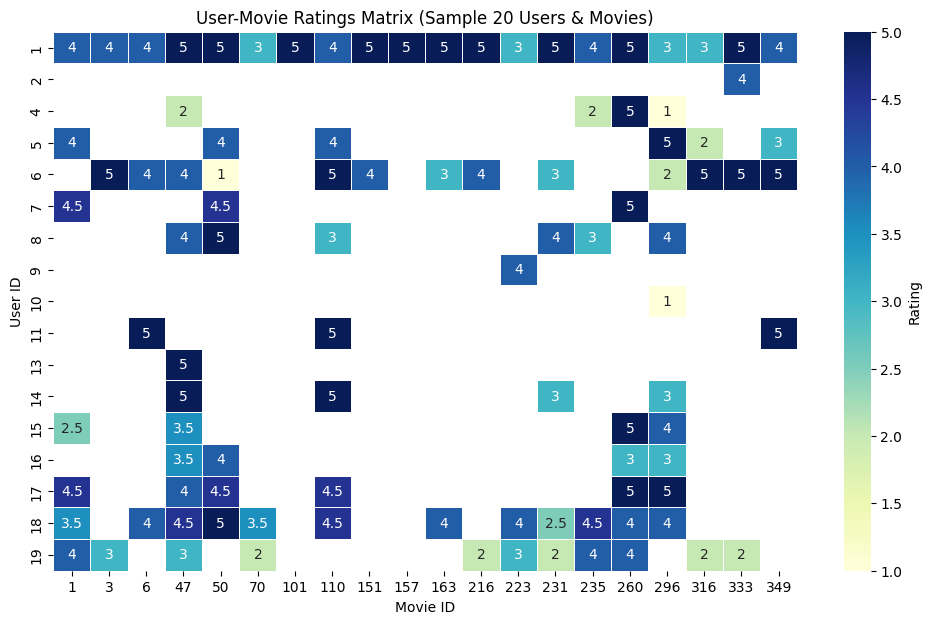

In [17]:
# Plot heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(user_movie_matrix, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Rating'}, linewidths=0.5)
plt.title('User-Movie Ratings Matrix (Sample 20 Users & Movies)')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.show()

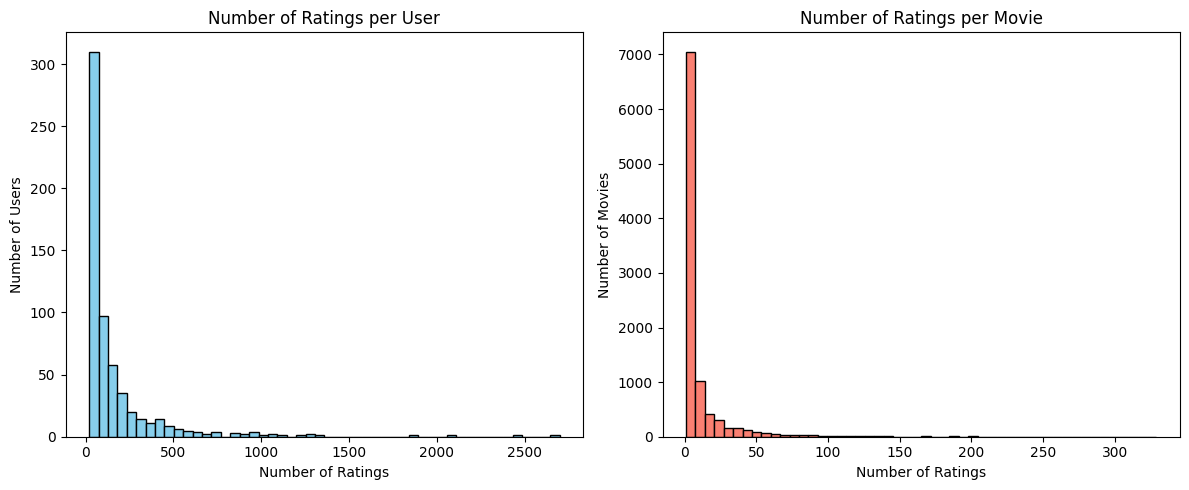

In [18]:
# Count ratings per user
ratings_per_user = ratings.groupby('userId').size()

# Count ratings per movie
ratings_per_movie = ratings.groupby('movieId').size()

# Plot histogram of ratings per user
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(ratings_per_user, bins=50, color='skyblue', edgecolor='black')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

# Plot histogram of ratings per movie
plt.subplot(1, 2, 2)
plt.hist(ratings_per_movie, bins=50, color='salmon', edgecolor='black')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')

plt.tight_layout()
plt.show()

#Content-Based Filtering (Movie-Genre + Tags)

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
movies = pd.read_csv('movies.csv')
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [58]:
# Step 1: Convert 'Action|Adventure|Sci-Fi' → 'Action Adventure Sci-Fi'
movies['genres'] = movies['genres'].str.replace('|', ' ', regex=False)

In [59]:
# Ensure clean column names
movies.columns = movies.columns.str.strip()
tags.columns = tags.columns.str.strip()
print(movies.columns)
print(tags.columns)

# Merge tags into one string per movie
tag_data = tags.groupby('movieId')['tag'].apply(lambda x: " ".join(x.astype(str))).reset_index()
print(tag_data.head())  # Check that movieId is present

Index(['movieId', 'title', 'genres', 'tag_x', 'combined_features', 'tag_y',
       'normalized_title', 'tag'],
      dtype='object')
Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
   movieId                                           tag
0        1                               pixar pixar fun
1        2  fantasy magic board game Robin Williams game
2        3                                     moldy old
3        5                              pregnancy remake
4        7                                        remake


In [61]:
# Merge tags with movies
if 'tag' in movies.columns:
    movies = movies.drop(columns=['tag'])

movies = movies.merge(tag_data, on='movieId', how='left')
print(movies.columns.tolist())
movies.head()

['movieId', 'title', 'genres', 'tag_x', 'combined_features', 'tag_y', 'normalized_title', 'tag']


,movieId,title,genres,tag_x,combined_features,tag_y,normalized_title,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,Adventure|Animation|Children|Comedy|Fantasy pi...,pixar pixar fun,toy story (1995),pixar pixar fun
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,Adventure|Children|Fantasy fantasy magic board...,fantasy magic board game Robin Williams game,jumanji (1995),fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,Comedy|Romance moldy old,moldy old,grumpier old men (1995),moldy old
3,4,Waiting to Exhale (1995),Comedy Drama Romance,NaN,Comedy|Drama|Romance,NaN,waiting to exhale (1995),NaN
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,Comedy pregnancy remake,pregnancy remake,father of the bride part ii (1995),pregnancy remake


In [63]:
# Step 2: Combine genres and tags as one text blob per movie
movies['combined_features'] = movies['genres'].fillna('') + " " + movies['tag'].fillna('')
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure Animation Children Comedy Fantasy   
1                   Adventure Children Fantasy   
2                               Comedy Romance   
3                         Comedy Drama Romance   
4                                       Comedy   

                                          tag_x  \
0                               pixar pixar fun   
1  fantasy magic board game Robin Williams game   
2                                     moldy old   
3                                           NaN   
4                              pregnancy remake   

                                   combined_features  \
0  Adventure Animation Children Com

In [64]:
# Use TF-IDF to vectorize text
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['combined_features'])

In [65]:
# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [66]:
# Build a reverse index for movie titles
movies['normalized_title'] = movies['title'].str.lower().str.strip()
indices = pd.Series(movies.index, index=movies['normalized_title']).drop_duplicates()
print(indices)

normalized_title
toy story (1995)                                0
jumanji (1995)                                  1
grumpier old men (1995)                         2
waiting to exhale (1995)                        3
father of the bride part ii (1995)              4
                                             ... 
black butler: book of the atlantic (2017)    9737
no game no life: zero (2017)                 9738
flint (2017)                                 9739
bungo stray dogs: dead apple (2018)          9740
andrew dice clay: dice rules (1991)          9741
Length: 9742, dtype: int64


In [69]:
def recommend_movies(title, top_n=5):
    title = title.lower()
    if title not in indices:
        print("Movie not found!")
        return pd.DataFrame()  # Return empty DataFrame if not found
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    # Return as DataFrame
    return movies.iloc[movie_indices][['title', 'genres']].reset_index(drop=True)

In [74]:
recommendations = recommend_movies('toy Story (1995)', top_n=10)
display(recommendations)

,title,genres
0,"Bug's Life, A (1998)",Adventure Animation Children Comedy
1,Toy Story 2 (1999),Adventure Animation Children Comedy Fantasy
2,Guardians of the Galaxy 2 (2017),Action Adventure Sci-Fi
3,Antz (1998),Adventure Animation Children Comedy Fantasy
4,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure Animation Children Comedy Fantasy
5,"Emperor's New Groove, The (2000)",Adventure Animation Children Comedy Fantasy
6,"Monsters, Inc. (2001)",Adventure Animation Children Comedy Fantasy
7,"Wild, The (2006)",Adventure Animation Children Comedy Fantasy
8,Shrek the Third (2007),Adventure Animation Children Comedy Fantasy
9,"Tale of Despereaux, The (2008)",Adventure Animation Children Comedy Fantasy


In [79]:
import plotly.graph_objects as go

def recommend_movies_plotly(title, top_n=10):
    title = title.lower()
    if title not in indices:
        print("Movie not found!")
        return

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    recommended_titles = movies.iloc[[i[0] for i in sim_scores]]['title'].values
    recommended_genres = movies.iloc[[i[0] for i in sim_scores]]['genres'].values
    similarity_scores = [round(i[1], 3) for i in sim_scores]

    fig = go.Figure(data=[go.Table(
        header=dict(values=['Title', 'Genre', 'Similarity Score'],
                    fill_color='lightblue',
                    align='left'),
        cells=dict(values=[recommended_titles, recommended_genres, similarity_scores],
                   fill_color='lavender',
                   align='left'))
    ])

    fig.update_layout(title=f'Recommendations for: {title.title()}')
    fig.show()

In [80]:
recommend_movies_plotly("toy Story (1995)")

#COLLABORATIVE FILTERING

In [86]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd

In [87]:
# Load data (MovieLens)
ratings = pd.read_csv('ratings.csv')

In [88]:
# Encode user and movie IDs
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}

In [93]:
ratings['user'] = ratings['userId'].map(user2user_encoded)
ratings['movie'] = ratings['movieId'].map(movie2movie_encoded)
num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)

In [94]:
# Build training set
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

In [102]:
# User input and embedding
user_input = layers.Input(shape=(1,))
user_embedding = layers.Embedding(num_users, 64)(user_input)
user_vec = layers.Flatten()(user_embedding)

# Movie input and embedding
movie_input = layers.Input(shape=(1,))
movie_embedding = layers.Embedding(num_movies, 64)(movie_input)
movie_vec = layers.Flatten()(movie_embedding)

# Concatenate and dense layers
concat = layers.Concatenate()([user_vec, movie_vec])
dense = layers.Dense(128, activation='relu')(concat)
dropout = layers.Dropout(0.5)(dense)
dense = layers.Dense(64, activation='relu')(dropout)
output = layers.Dense(1)(dense)

# Compile the model
model = tf.keras.Model([user_input, movie_input], output)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 64)     │     39,040 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 64)     │    622,336 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 64)        │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 64)        │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128)       │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,512 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         65 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 686,209 (2.62 MB)

 Trainable params: 686,209 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
history = model.fit(
    x=[X[:, 0], X[:, 1]],
    y=y,
    batch_size=64,
    epochs=5,
    validation_split=0.2
)


Epoch 1/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 2.3738 - val_loss: 1.0061
Epoch 2/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.7734 - val_loss: 0.9782
Epoch 3/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.6929 - val_loss: 0.9700
Epoch 4/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.6550 - val_loss: 0.9778
Epoch 5/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.6222 - val_loss: 0.9683


In [107]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def recommend_movies(user_id, n=5):
    # Encode the user
    user_encoded = user2user_encoded[user_id]
    watched_movies = ratings[ratings['userId'] == user_id]['movieId'].map(movie2movie_encoded)

    # Find unwatched movies
    all_movie_indices = np.array(list(movie2movie_encoded.values()))
    unwatched = np.setdiff1d(all_movie_indices, watched_movies)

    # Predict ratings
    user_array = np.full_like(unwatched, fill_value=user_encoded)
    preds = model.predict([user_array, unwatched], verbose=0)

    # Get top-N recommendations
    top_indices = preds.flatten().argsort()[-n:][::-1]
    recommended_movie_ids = [movie_ids[i] for i in unwatched[top_indices]]

    # Fetch movie details
    movie_df = pd.read_csv('movies.csv')
    recommended = movie_df[movie_df['movieId'].isin(recommended_movie_ids)][['title', 'genres']]

    # Plot as table using Plotly
    fig = go.Figure(data=[go.Table(
        header=dict(values=["Title", "Genres"],
                    fill_color='lightblue',
                    align='left'),
        cells=dict(values=[recommended['title'], recommended['genres']],
                   fill_color='lavender',
                   align='left'))
    ])

    fig.update_layout(title=f"Top {n} Movie Recommendations for User {user_id}")
    fig.show()


In [109]:
# Example usage
recommend_movies(user_id=1, n=10)

In [121]:
model.save('movie_rec_model.h5')


#Hybrid System

In [130]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go

def hybrid_recommend(user_id, movie_title, top_n=5, alpha=0.5):
    """
    alpha = weight for content-based (0.0 to 1.0)
    (1 - alpha) = weight for collaborative-based
    """

    # Step 1: Content-based similarity
    idx = indices.get(movie_title.lower())
    if idx is None:
        print("Movie not found!")
        return

    content_scores = list(enumerate(cosine_sim[idx]))
    content_scores = sorted(content_scores, key=lambda x: x[1], reverse=True)[1:top_n * 10]
    candidate_indices = [i[0] for i in content_scores]
    candidate_movie_ids = movies.iloc[candidate_indices]['movieId'].values

    # Step 2: Collaborative filtering predictions
    user_encoded = user2user_encoded[user_id]
    candidate_movie_encoded = [movie2movie_encoded.get(mid) for mid in candidate_movie_ids if mid in movie2movie_encoded]
    filtered_movie_ids = [mid for mid in candidate_movie_ids if mid in movie2movie_encoded]

    user_array = np.full(len(candidate_movie_encoded), user_encoded)
    movie_array = np.array(candidate_movie_encoded)

    preds = model.predict([user_array, movie_array], verbose=0).flatten()

    # Step 3: Combine both scores
    content_sim = np.array([cosine_sim[idx][indices[movies[movies['movieId'] == mid]['title'].values[0].lower()]] for mid in filtered_movie_ids])
    hybrid_scores = alpha * content_sim[:len(preds)] + (1 - alpha) * preds

    top_indices = hybrid_scores.argsort()[-top_n:][::-1]
    final_movie_ids = [filtered_movie_ids[i] for i in top_indices]

    # Step 4: Display results
    final_movies = pd.read_csv("movies.csv")
    recommended = final_movies[final_movies['movieId'].isin(final_movie_ids)][['title', 'genres']]

    fig = go.Figure(data=[go.Table(
        header=dict(values=["Title", "Genres"],
                    fill_color='lightblue',
                    align='left'),
        cells=dict(values=[recommended['title'], recommended['genres']],
                   fill_color='lavender',
                   align='left'))
    ])
    fig.update_layout(title=f"Top {top_n} Hybrid Recommendations for User {user_id}")
    fig.show()


In [118]:
query = input("Enter part of a movie title: ")
matches = search_movie(query)

if len(matches) > 0:
    print("Did you mean:")
    for i, row in matches.iterrows():
        print(f"{i+1}. {row['title']}")
    choice = int(input("Enter the number of the correct movie: ")) - 1
    selected_title = matches.iloc[choice]['title']
    hybrid_recommend(user_id=1, movie_title=selected_title, top_n=5, alpha=0.6)
else:
    print("No matching movies found.")


Enter part of a movie title: toy
Did you mean:
1. Toy Story (1995)
1493. Babes in Toyland (1961)
1675. Toys (1992)
2330. Babes in Toyland (1934)
2356. Toy Story 2 (1999)
Enter the number of the correct movie: 1


#Streamlit

In [127]:
pip install streamlit pandas scikit-learn tensorflow plotly


In [150]:
!pip install streamlit pyngrok


In [162]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model

# === Load data ===
movies = pd.read_csv("movies.csv")  # movieId, title, genres
ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")

# === Preprocess tags ===
tag_data = tags.groupby('movieId')['tag'].apply(lambda x: " ".join(x)).reset_index()
movies = movies.merge(tag_data, on='movieId', how='left')
movies['combined_features'] = movies['genres'].fillna('') + ' ' + movies['tag'].fillna('')

# === Content-based TF-IDF ===
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['combined_features'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies.index, index=movies['title'].str.lower().str.strip()).drop_duplicates()


# === Collaborative filtering model ===
# Load your trained Keras model (update filename accordingly)
model = load_model('movie_rec_model.h5')

# === Encode userId and movieId ===
user_ids = ratings['userId'].unique().tolist()
movie_ids = ratings['movieId'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for x, i in movie2movie_encoded.items()}

# === Recommend function ===
def hybrid_recommend(user_id, movie_title, top_n=5, alpha=0.5):
    title = movie_title.lower().strip()
    if title not in indices:
        return None

    idx = indices[title]
    content_scores = cosine_sim[idx]

    if user_id not in user2user_encoded:
        return movies.iloc[content_scores.argsort()[-top_n:][::-1]][['title', 'genres']]

    encoded_user = user2user_encoded[user_id]
    all_movie_indices = np.array(list(movie2movie_encoded.values()))

    watched_movies = ratings[ratings['userId'] == user_id]['movieId'].map(movie2movie_encoded)
    unwatched = np.setdiff1d(all_movie_indices, watched_movies)

    user_array = np.full_like(unwatched, fill_value=encoded_user)
    preds = model.predict([user_array, unwatched], verbose=0).flatten()

    collaborative_scores = np.zeros_like(content_scores)
    for i, movie_encoded_idx in enumerate(unwatched):
      real_id = movie_encoded2movie[movie_encoded_idx]
      content_idx = movies[movies['movieId'] == real_id].index
      if len(content_idx) > 0:
        collaborative_scores[content_idx[0]] = preds[i]  # Use i, NOT movie_encoded_idx


    hybrid_scores = alpha * content_scores + (1 - alpha) * collaborative_scores
    hybrid_indices = hybrid_scores.argsort()[-top_n:][::-1]

    return movies.iloc[hybrid_indices][['title', 'genres']]

# === Search function ===
def search_movie(partial_title, n=5):
    partial_title = partial_title.lower()
    return movies[movies['title'].str.lower().str.contains(partial_title)].head(n)[['title']]

# === Streamlit UI ===
st.title("🎬 Real-Time Hybrid Movie Recommender")

user_id = st.number_input("Enter User ID", min_value=1, step=1)
query = st.text_input("Start typing a movie title")

if query:
    matches = search_movie(query)
    if not matches.empty:
        selected_title = st.selectbox("Select a movie:", matches['title'].tolist())
        if st.button("Recommend"):
            recs = hybrid_recommend(user_id, selected_title, top_n=5)
            if recs is not None and not recs.empty:
                st.success("Top Recommendations:")
                fig = px.bar(recs, x='title', y=[1]*len(recs), hover_data=['genres'], labels={'y': 'Score'})
                st.plotly_chart(fig, use_container_width=True)
                st.dataframe(recs)
            else:
                st.error("No recommendations found!")
    else:
        st.warning("No movies found matching your search.")



Overwriting app.py


In [164]:
!ngrok config add-authtoken 2xRrSQFTDLFsPI5O0X2v5DyoQhV_21Q5Pn9c5wcmiDLaZNhJj

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [166]:
from pyngrok import ngrok

# Kill all tunnels
ngrok.kill()

# Then start new tunnel again
public_url = ngrok.connect("http://localhost:8501")
print("Streamlit app is live at:", public_url)


Streamlit app is live at: NgrokTunnel: "https://d3d9-35-234-14-245.ngrok-free.app" -> "http://localhost:8501"


In [171]:
!git clone https://github.com/pal1501/Movie-Recommendation.git

fatal: destination path 'Movie-Recommendation' already exists and is not an empty directory.


In [170]:
!git add .
!git commit -m "Updated files"
!git push origin main  # Change 'main' to your branch name


fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
